In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

In [59]:
df = pd.read_csv(r'C:\Users\hi\Desktop\dse\analytics vidhya\janata e-comm\train_8wry4cB.csv')
test = pd.read_csv(r'C:\Users\hi\Desktop\dse\analytics vidhya\janata e-comm\test_Yix80N0.csv')

In [166]:
df.head(10)

,session_id,startTime,endTime,ProductList,gender,data_set
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female,train
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male,train
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female,train
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female,train
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male,train
5,u20964,12/12/14 15:31,12/12/14 15:31,A00002/B00002/C00081/D25039/,female,train
6,u20981,05/12/14 19:33,05/12/14 19:34,A00002/B00011/C00180/D18487/;A00002/B00011/C00...,female,train
7,u15947,09/12/14 16:02,09/12/14 16:06,A00002/B00001/C00059/D15254/;A00002/B00001/C00...,male,train
8,u18193,25/11/14 11:55,25/11/14 11:55,A00002/B00001/C00010/D06129/,male,train
9,u21820,06/12/14 16:16,06/12/14 16:17,A00002/B00001/C00010/D12841/;A00002/B00002/C00...,female,train


In [60]:
df['data_set'] = 'train'
test['data_set'] = 'test'
test['gender'] = 0

In [61]:
data = pd.concat([df,test])

C:\Users\hi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [43]:
def processing(data):
    data["cate"]=data["ProductList"].apply(lambda x:list(set(re.findall('(?<=A000)[0-9][0-9]',x,re.DOTALL))))
    data["sub_cate"]=data["ProductList"].apply(lambda x:list(set(re.findall('(?<=B)[0-9][0-9][0-9][0-9][0-9]',x,re.DOTALL))))
    data["sub_sub_cate"]=data["ProductList"].apply(lambda x:list(set(re.findall('(?<=C)[0-9][0-9][0-9][0-9][0-9]',x,re.DOTALL))))
    data["product_id"]=data["ProductList"].apply(lambda x:list(set(re.findall('(?<=D)[0-9][0-9][0-9][0-9][0-9]',x,re.DOTALL))))
    data["No_Of_Products_Viewed"]=data["product_id"].apply(lambda x:len(x))
    data["startTime"]=pd.to_datetime(data["startTime"])
    data["endTime"]=pd.to_datetime(data["endTime"])
   # data["Session_duration"]=data.apply(timedelta,axis=1)
    data['spent_time'] = data['endTime'].sub(data['startTime'], axis=0)
    data['day_s'] = data.startTime.dt.day
    data['month_s'] = data.startTime.dt.month
    data['year_s'] = data.startTime.dt.year
    data['hour_s'] = data.startTime.dt.hour
    data['minute_s'] = data.startTime.dt.minute
    data['day_e'] = data.endTime.dt.day
    data['month_e'] = data.endTime.dt.month
    data['year_e'] = data.endTime.dt.year
    data['hour_e'] = data.endTime.dt.hour
    data['minute_e'] = data.endTime.dt.minute
    data[['cat_1','cat_2','cat_3']]=pd.DataFrame(data.cate.values.tolist())
    data[['sub_cat_1','sub_cat_2','sub_cat_3','sub_cat_4','sub_cat_5','sub_cat_6','sub_cat_7']]=pd.DataFrame(data.sub_cate.values.tolist())
    data[['sub_sub_cat_1','sub_sub_cat_2','sub_sub_cat_3','sub_sub_cat_4','sub_sub_cat_5','sub_sub_cat_6','sub_sub_cat_7','sub_sub_cat_8','sub_sub_cat_9','sub_sub_cat_10','sub_sub_cat_11','sub_sub_cat_12','sub_sub_cat_13']]=pd.DataFrame(data.sub_sub_cate.values.tolist())
    data = data.fillna(0)
    data = data.drop(['ProductList','cate','sub_cate','sub_sub_cate','product_id','startTime','endTime'],axis=1)
    data['spent_time'] = data['spent_time'].astype('timedelta64[m]')
    return data

In [55]:
def converting(d):
    colm = list(d.columns)
    for i in colm:
        if (i != 'session_id'):
            d[i] = d[i].astype(int)

In [90]:
def model_eval(model,xtrain,ytrain,xtest,ytest):
    model.fit(xtrain,ytrain)

    y_train_pred=model.predict(xtrain)
    y_train_prob=model.predict_proba(xtrain)[:,1]
    
    y_test_pred=model.predict(xtest)
    y_test_prob=model.predict_proba(xtest)[:,1]
    print(model)
    print('\n'*1)
    print(' Accuracy score of train: ', accuracy_score(ytrain,y_train_pred))
    print(' Accuracy score of test: ', accuracy_score(ytest,y_test_pred))
    print('\n'*1)
    print(' Confusion Matrix of train: ', confusion_matrix(ytrain,y_train_pred))
    print(' Confusion Matrix of test: ', confusion_matrix(ytest,y_test_pred))
    print('\n'*1)
    print(' Auc of train: ', roc_auc_score(ytrain,y_train_prob))
    print(' Auc of test: ', roc_auc_score(ytest,y_test_prob))

In [62]:
data_n = processing(data)

C:\Users\hi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.


In [117]:
train = data_n[data_n['data_set']=='train'].drop('data_set',axis=1)
test_n = data_n[data_n['data_set']=='test'].drop(['gender','data_set'],axis=1)

In [74]:
train['gender'] = train['gender'].map({'female':0,'male':1})


In [75]:
colm = list(train.columns)
for i in colm:
    if (i != 'session_id'):
        train[i] = train[i].astype(int)

In [81]:
x = train.drop(['session_id','gender'],axis=1)
y = train['gender']
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.30, random_state=1)

In [91]:
dtc=DecisionTreeClassifier(max_depth=5)
model_eval(dtc,x_train,y_train,x_validate,y_validate)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


 Accuracy score of train:  0.8760544217687075
 Accuracy score of test:  0.8752380952380953


 Confusion Matrix of train:  [[5474  253]
 [ 658  965]]
 Confusion Matrix of test:  [[2356  109]
 [ 284  401]]


 Auc of train:  0.8039166766452345
 Auc of test:  0.8031373536074385


In [95]:
model = RandomForestClassifier(n_estimators=10)
model_eval(model,x_train,y_train,x_validate,y_validate)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


 Accuracy score of train:  0.9824489795918367
 Accuracy score of test:  0.8606349206349206


 Confusion Matrix of train:  [[5718    9]
 [ 120 1503]]
 Confusion Matrix of test:  [[2363  102]
 [ 337  348]]


 Auc of train:  0.9994665366171482
 Auc of test:  0.813312506477547


In [133]:
lgbc = lgb.LGBMClassifier()
#model_eval(model,x_train,y_train,x_validate,y_validate)

In [134]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

params = {
    'n_estimators' : sp_randint(50,200),
    'num_leaves': sp_randint(10,50),
    'max_depth' : sp_randint(2,15),
    'learning_rate': sp_uniform(0,1),
    'min_child_samples' : sp_randint(2,50)}

rsearch_lgbm = RandomizedSearchCV(lgbc,param_distributions=params,cv=3,random_state=1,n_jobs=-1,n_iter=200,scoring='roc_auc',return_train_score=)

rsearch_lgbm.fit(x,y)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024

In [135]:
rsearch_lgbm.cv

{'learning_rate': 0.0679686376915134,
 'max_depth': 6,
 'min_child_samples': 35,
 'n_estimators': 192,
 'num_leaves': 18}

In [136]:
lgbc  = lgb.LGBMClassifier(**rsearch_lgbm.best_params_)
model_eval(lgbc,x_train,y_train,x_validate,y_validate)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.0679686376915134,
               max_depth=6, min_child_samples=35, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=192, n_jobs=-1, num_leaves=18,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


 Accuracy score of train:  0.8882993197278911
 Accuracy score of test:  0.8768253968253968


 Confusion Matrix of train:  [[5529  198]
 [ 623 1000]]
 Confusion Matrix of test:  [[2361  104]
 [ 284  401]]


 Auc of train:  0.9291174179963444
 Auc of test:  0.8294008083978619


In [103]:
from bayes_opt import BayesianOptimization
dtrain=xgb.DMatrix(x_train,y_train.ravel())
cv_results=[]
par=[]
def bo_tune_xgb(max_depth,min_child_weight,n_estimators,gamma):
    params = {'max_depth': int(round(max_depth)),
              'min_child_weight': int(round(min_child_weight)),
              'eval_metric': 'acc',
              'n_estimators':int(round(n_estimators)),
              #"learning_rate":.1,
              'gamma':gamma,
              'objective':'binary:logistic'
             }
    cv_result = xgb.cv(params,dtrain,num_boost_round=20,metrics="auc",nfold=3)    
    cv_results.append(cv_result)
    par.append(params)
    #Return the negative RMSE
    print(cv_result)
    return max(cv_result["test-auc-mean"])

xgb_bo = BayesianOptimization(bo_tune_xgb, {
                                            "max_depth"        : (10,50),
                                            "min_child_weight" : (1,150),
                                            "n_estimators"     : (50,300),
                                            "gamma"            :(0,1)
                                        })

xgb_bo.maximize(init_points=10, n_iter=30)

|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.804187       0.003755       0.793319      0.011946
1         0.810869       0.007085       0.794031      0.011995
2         0.813183       0.007340       0.796122      0.009413
3         0.813596       0.008232       0.796907      0.009984
4         0.814272       0.008002       0.798275      0.007386
5         0.815751       0.006639       0.802172      0.007761
6         0.816471       0.005626       0.801054      0.007136
7         0.816156       0.006122       0.799759      0.009306
8         0.818724       0.005217       0.802096      0.009774
9         0.819870       0.005253       0.802401      0.010006
10        0.820379       0.005531       0.802155      0.010250
11        0.821352       0.005020       0.802937      0.010923
12        0.821714       0.004867

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.816113       0.005571       0.791616      0.014676
1         0.829671       0.002563       0.800471      0.018128
2         0.834857       0.002756       0.806762      0.011928
3         0.840935       0.002871       0.810176      0.008891
4         0.844594       0.002320       0.810918      0.009519
5         0.846162       0.002177       0.812928      0.010599
6         0.847186       0.001697       0.813716      0.010166
7         0.848930       0.001616       0.814301      0.010719
8         0.850099       0.002351       0.814796      0.011799
9         0.852134       0.002158       0.814703      0.011159
10        0.853159       0.002109       0.815769      0.011511
11        0.855874       0.002170       0.816972      0.011445
12        0.857414       0.001941       0.815995      0.013012
13        0.858207       0.001858       0.816458      0.012765
14        0.860066       0.001791       0.817406      0

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.854203       0.001122       0.794815      0.016469
1         0.883271       0.008842       0.804010      0.013791
2         0.905098       0.004755       0.805598      0.015219
3         0.926939       0.004157       0.810201      0.012470
4         0.938238       0.002374       0.809442      0.009563
5         0.947138       0.001383       0.810344      0.012708
6         0.955499       0.001303       0.814428      0.009668
7         0.962144       0.001570       0.817006      0.008427
8         0.966956       0.001402       0.818527      0.006379
9         0.969260       0.000688       0.818451      0.006495
10        0.971726       0.000743       0.818827      0.005978
11        0.974342       0.000884       0.818338      0.005040
12        0.977263       0.000786       0.818746      0.004951
13        0.979066       0.001283       0.819503      0.004922
14        0.980079       0.001156       0.820571      0

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.807345       0.005892       0.789958      0.014454
1         0.818861       0.008935       0.800146      0.007115
2         0.826545       0.009638       0.807143      0.007408
3         0.828135       0.008448       0.806160      0.005384
4         0.829617       0.008455       0.805883      0.005369
5         0.831806       0.006918       0.808612      0.007769
6         0.834258       0.007406       0.809409      0.006327
7         0.834065       0.006462       0.810136      0.006907
8         0.833820       0.007260       0.809354      0.006556
9         0.835275       0.006523       0.811745      0.007263
10        0.836561       0.005729       0.813207      0.007617
11        0.837286       0.005935       0.813472      0.008218
12        0.839602       0.005310       0.814157      0.008295
13        0.840542       0.005425       0.814744      0.008535
14        0.841507       0.005163       0.814547      0

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.836045       0.010025       0.798013      0.014163
1         0.866244       0.005613       0.804932      0.013323
2         0.880441       0.010503       0.810571      0.017356
3         0.890595       0.007586       0.813252      0.014594
4         0.899664       0.005538       0.815118      0.013962
5         0.905826       0.004950       0.812982      0.015453
6         0.914408       0.004039       0.813866      0.015099
7         0.918880       0.003483       0.815460      0.014262
8         0.923440       0.003510       0.814891      0.014514
9         0.927182       0.003463       0.817254      0.015973
10        0.929914       0.003145       0.817290      0.015975
11        0.932775       0.002778       0.817248      0.014630
12        0.934756       0.002389       0.818028      0.013128
13        0.936524       0.002339       0.818215      0.013347
14        0.938413       0.003053       0.819308      0

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.845705       0.007062       0.797933      0.015152
1         0.876160       0.009435       0.808267      0.015226
2         0.893363       0.010069       0.812330      0.012542
3         0.911914       0.003911       0.815414      0.009659
4         0.923978       0.003447       0.812781      0.009135
5         0.935295       0.002085       0.811771      0.010530
6         0.944362       0.002116       0.815033      0.009743
7         0.950609       0.001194       0.815637      0.009245
8         0.953877       0.002384       0.817583      0.009624
9         0.958409       0.002359       0.816178      0.008760
10        0.961951       0.002555       0.816189      0.008562
11        0.965216       0.003183       0.817353      0.007340
12        0.966520       0.003796       0.817423      0.005918
13        0.969809       0.003503       0.817089      0.005583
14        0.971710       0.003835       0.817598      0

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.833025       0.012054       0.798325      0.015480
1         0.860839       0.005155       0.804202      0.013350
2         0.874994       0.009303       0.815370      0.013588
3         0.887316       0.007614       0.812976      0.012353
4         0.895544       0.007181       0.814914      0.013201
5         0.903533       0.005400       0.818755      0.011120
6         0.907631       0.005164       0.816378      0.009293
7         0.913680       0.004401       0.819502      0.010723
8         0.916885       0.004557       0.819310      0.010303
9         0.921401       0.003549       0.821510      0.010396
10        0.925426       0.002209       0.820859      0.009618
11        0.927678       0.001962       0.820764      0.009550
12        0.931468       0.002695       0.820397      0.011009
13        0.934823       0.001103       0.822302      0.010298
14        0.936809       0.002286       0.822445      0

In [104]:
params = xgb_bo.max['params']

print(params)

#Conversting the max_depth and n_estimator values from float to int
params['max_depth']= int(round(params['max_depth']))
params['gamma']= params['gamma']
params['n_estimators']= int(round(params['n_estimators']))
params['min_child_weight']= int(round(params['min_child_weight']))
#params['max_bin']= int(round(params['max_bin']))
print(params)


{'gamma': 0.7656846269031595, 'max_depth': 12.13046182073545, 'min_child_weight': 3.672811397108462, 'n_estimators': 209.14844934930844}
{'gamma': 0.7656846269031595, 'max_depth': 12, 'min_child_weight': 4, 'n_estimators': 209}


In [105]:
model_eval(xgb.XGBClassifier(**params),x_train,y_train,x_validate,y_validate)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.7656846269031595,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=4, missing=None, n_estimators=209, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


 Accuracy score of train:  0.9333333333333333
 Accuracy score of test:  0.8742857142857143


 Confusion Matrix of train:  [[5660   67]
 [ 423 1200]]
 Confusion Matrix of test:  [[2365  100]
 [ 296  389]]


 Auc of train:  0.9837703300544459
 Auc of test:  0.8292557113457011


In [107]:
train.shape,test_n.shape

((10500, 37), (4500, 36))

In [137]:
model=lgb.LGBMClassifier(**rsearch_lgbm.best_params_)
model.fit(x,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.0679686376915134,
               max_depth=6, min_child_samples=35, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=192, n_jobs=-1, num_leaves=18,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [110]:
test_n.shape,x.shape

((4500, 36), (10500, 35))

In [118]:
test_new=test_n.drop('session_id',axis=1)

In [120]:
colm = list(test_new.columns)
for i in colm:
    if (i != 'session_id'):
        test_new[i] = test_new[i].astype(int)

In [138]:
pred=model.predict(test_new)

In [139]:
sub=pd.read_csv("sample_submission_opxHi4g.csv")
sub["gender"]=pred
sub["gender"]=sub["gender"].map({0:"female",1:"male"})

In [142]:
sub.gender.value_counts()

female    3775
male       725
Name: gender, dtype: int64

In [127]:
test.shape

(4500, 6)

In [140]:
sub[['session_id', 'gender']].to_csv('submission.csv',index=False)

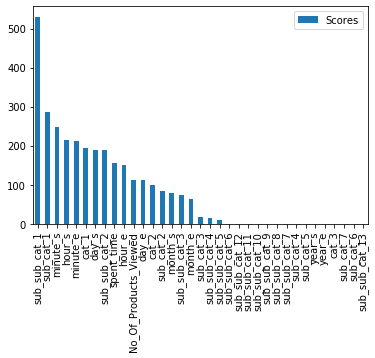

In [141]:
pd.DataFrame(index=x.columns,data=model.feature_importances_,columns=["Scores"]).sort_values("Scores",ascending=False).plot.bar()

In [143]:
train.head()

,gender,session_id,No_Of_Products_Viewed,spent_time,day_s,month_s,year_s,hour_s,minute_s,day_e,month_e,year_e,hour_e,minute_e,cat_1,cat_2,cat_3,sub_cat_1,sub_cat_2,sub_cat_3,sub_cat_4,sub_cat_5,sub_cat_6,sub_cat_7,sub_sub_cat_1,sub_sub_cat_2,sub_sub_cat_3,sub_sub_cat_4,sub_sub_cat_5,sub_sub_cat_6,sub_sub_cat_7,sub_sub_cat_8,sub_sub_cat_9,sub_sub_cat_10,sub_sub_cat_11,sub_sub_cat_12,sub_sub_cat_13
0,0,u16159,4,1,15,12,2014,18,11,15,12,2014,18,12,2,0,0,3,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0
1,1,u10253,7,6,16,12,2014,14,35,16,12,2014,14,41,1,0,0,9,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0
2,0,u19037,1,0,12,1,2014,15,58,12,1,2014,15,58,2,0,0,1,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0
3,0,u14556,3,3,23,11,2014,2,57,23,11,2014,3,0,2,0,0,4,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0
4,1,u24295,2,2,17,12,2014,16,44,17,12,2014,16,46,1,0,0,1,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0


In [148]:
train.drop(['year_s','year_e'],axis=1,inplace=True)

In [149]:
train.head()

,gender,session_id,No_Of_Products_Viewed,spent_time,day_s,month_s,hour_s,minute_s,day_e,month_e,hour_e,minute_e,cat_1,cat_2,cat_3,sub_cat_1,sub_cat_2,sub_cat_3,sub_cat_4,sub_cat_5,sub_cat_6,sub_cat_7,sub_sub_cat_1,sub_sub_cat_2,sub_sub_cat_3,sub_sub_cat_4,sub_sub_cat_5,sub_sub_cat_6,sub_sub_cat_7,sub_sub_cat_8,sub_sub_cat_9,sub_sub_cat_10,sub_sub_cat_11,sub_sub_cat_12,sub_sub_cat_13
0,0,u16159,4,1,15,12,18,11,15,12,18,12,2,0,0,3,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0
1,1,u10253,7,6,16,12,14,35,16,12,14,41,1,0,0,9,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0
2,0,u19037,1,0,12,1,15,58,12,1,15,58,2,0,0,1,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0
3,0,u14556,3,3,23,11,2,57,23,11,3,0,2,0,0,4,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0
4,1,u24295,2,2,17,12,16,44,17,12,16,46,1,0,0,1,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0


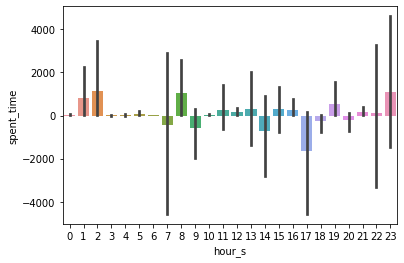

In [155]:
sns.barplot(x='hour_s',y='spent_time',data=train)
plt.show()

In [157]:
train[train['spent_time']<0]['session_id']

62       u18364
537      u14172
773      u16554
3251     u15865
4393     u16077
4701     u17625
5090     u19930
6084     u19424
6920     u12879
6969     u18555
8023     u15191
8286     u14304
9297     u17985
9777     u16794
10022    u18822
10140    u14037
Name: session_id, dtype: object

In [165]:
train['spent_time'].describe()

count     10500.000000
mean         47.764857
std       17410.367443
min     -459847.000000
25%           0.000000
50%           0.000000
75%           2.000000
max      486685.000000
Name: spent_time, dtype: float64

In [158]:
df[df['session_id']=='u19930']

,session_id,startTime,endTime,ProductList,gender,data_set
5090,u19930,30/11/14 23:30,07/12/14 23:50,A00002/B00002/C00002/D16165/;A00002/B00002/C00...,female,train


In [159]:
train[train['session_id']=='u19930']

,gender,session_id,No_Of_Products_Viewed,spent_time,day_s,month_s,hour_s,minute_s,day_e,month_e,hour_e,minute_e,cat_1,cat_2,cat_3,sub_cat_1,sub_cat_2,sub_cat_3,sub_cat_4,sub_cat_5,sub_cat_6,sub_cat_7,sub_sub_cat_1,sub_sub_cat_2,sub_sub_cat_3,sub_sub_cat_4,sub_sub_cat_5,sub_sub_cat_6,sub_sub_cat_7,sub_sub_cat_8,sub_sub_cat_9,sub_sub_cat_10,sub_sub_cat_11,sub_sub_cat_12,sub_sub_cat_13
5090,0,u19930,2,-203020,30,11,23,30,12,7,23,50,2,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0


In [167]:
df[df]

NameError: name 'date' is not defined

In [ ]:
from datetime import date

d0 = date(2008, 8, 18)
d1 = date(2008, 9, 26)
delta = d1 - d0